In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas.plotting import scatter_matrix
from pandas import Series, DataFrame

In [2]:
import math

start = datetime.datetime(2009, 12, 31)
# end = datetime.datetime(2017, 1, 11)
end = datetime.datetime.now()
df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002
2019-09-05,213.960007,211.509995,212.000000,213.279999,23946984.0,213.279999


In [3]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-12-31,26.272409,88102700.0,1.323968,-1.126074
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538


In [4]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(2436, 4)
Dimension of X (2411, 4)
Dimension of y (2411,)


In [5]:

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt


In [6]:

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

# Lasso regression
clflasso=Lasso()
clflasso.fit(X, y)

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidencelasso= clflasso.score(X_test, y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The lasso regression confidence is ",confidencelasso)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9667627040877486
The quadratic regression 2 confidence is  0.9654763605644529
The quadratic regression 3 confidence is  0.9392181555079536
The lasso regression confidence is  0.9667580759695565
The knn regression confidence is  0.9544867885614678


In [7]:
# # Printing the forecast
# forecast_set = clfreg.predict(X_lately)
# dfreg['Forecast'] = np.nan

# last_date = dfreg.iloc[-1].name
# last_unix = last_date
# next_unix = last_unix + datetime.timedelta(days=1)

# for i in forecast_set:
#     next_date = next_unix
#     next_unix += datetime.timedelta(days=1)
#     dfreg.lnext_dateoc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

# dfreg['Adj Close'].tail(500).plot()
# dfreg['Forecast'].tail(500).plot()
# plt.legend(loc=4)
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

In [8]:
def forecast( df, forecast_set):
    
#     next_unix = 0
    df['Forecast'] = np.nan
    next_unix = df.iloc[-1].name + datetime.timedelta(days=1)

    for i in forecast_set:
        next_unix += datetime.timedelta(days=1)
        df.loc[next_unix] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    
    return df

The linear regression confidence is  0.9742304212238455


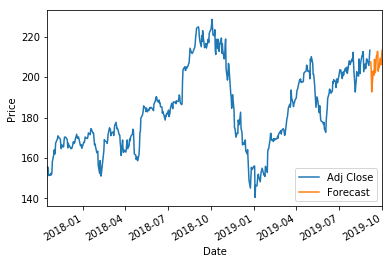

In [9]:
print("The linear regression confidence is ",confidencereg)

df_clfreg = forecast(dfreg, clfreg.predict(X_lately))
df_clfreg['Adj Close'].tail(500).plot()
df_clfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


The lasso regression confidence is  0.966541526864036


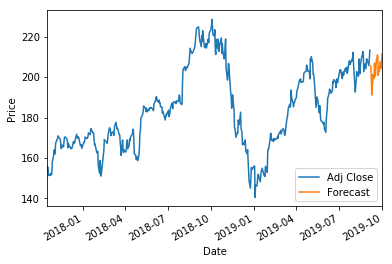

In [9]:
 
print("The lasso regression confidence is ",confidencelasso)
 

df_clflasso = forecast(dfreg, clflasso.predict(X_lately))

df_clflasso['Adj Close'].tail(500).plot()
df_clflasso['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

The quadratic regression 3 confidence is  0.9700190298151962


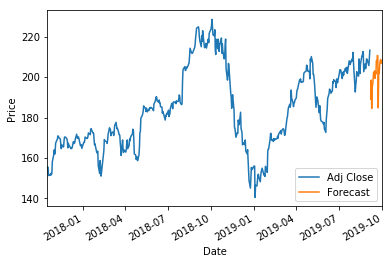

In [9]:

print("The quadratic regression 3 confidence is ",confidencepoly3)


df_clfpoly3 = forecast(dfreg, clfpoly3.predict(X_lately))


df_clfpoly3['Adj Close'].tail(500).plot()
df_clfpoly3['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


The quadratic regression 2 confidence is  0.9581613689682223


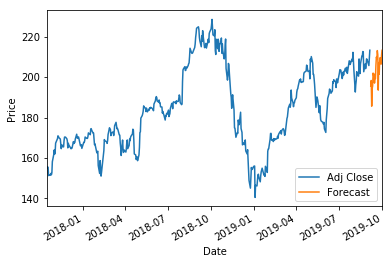

In [9]:

print("The quadratic regression 2 confidence is ",confidencepoly2)


df_clfpoly2 = forecast(dfreg, clfpoly2.predict(X_lately))

df_clfpoly2['Adj Close'].tail(500).plot()
df_clfpoly2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


The knn regression confidence is  0.9544867885614678


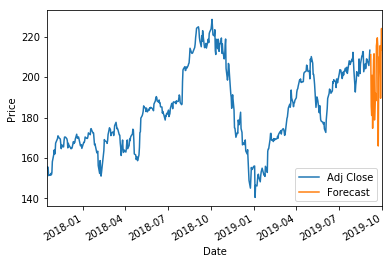

In [9]:

print("The knn regression confidence is ",confidenceknn)
df_clfknn = forecast(dfreg, clfknn.predict(X_lately))

df_clfknn['Adj Close'].tail(500).plot()
df_clfknn['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
